In [1]:
import scanpy as sc
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

# scTRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# File paths
DATA_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
FIG_PATH = '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/results/fig_hep'
DS_LIST = ['facs']

# Score files
DIC_SCORE_PATH = {'facs': DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_1000'}

DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST = {'facs': ['UKB_460K.biochemistry_LDLdirect']}

In [3]:
# Load raw data 
dic_data_raw = {}
dic_data_raw['facs'] = dl.load_tms_ct(DATA_PATH, data_name='facs')
# dic_data_raw['droplet'] = dl.load_tms_ct(DATA_PATH, data_name='droplet')

Trying to set attribute `.obs` of view, copying.


In [4]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = join(DIC_SCORE_PATH[score], '%s.score.gz'%trait)
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)   

### Get data for only hepatocytes and rerun harmony+umap

facs
Before filtering, n_cell=1162
After filtering, n_cell=1162


2021-08-25 00:09:25,325 - harmonypy - INFO - Iteration 1 of 20
2021-08-25 00:09:25,491 - harmonypy - INFO - Iteration 2 of 20
2021-08-25 00:09:25,648 - harmonypy - INFO - Iteration 3 of 20
2021-08-25 00:09:25,805 - harmonypy - INFO - Iteration 4 of 20
2021-08-25 00:09:25,892 - harmonypy - INFO - Iteration 5 of 20
2021-08-25 00:09:25,972 - harmonypy - INFO - Iteration 6 of 20
2021-08-25 00:09:26,038 - harmonypy - INFO - Iteration 7 of 20
2021-08-25 00:09:26,104 - harmonypy - INFO - Iteration 8 of 20
2021-08-25 00:09:26,170 - harmonypy - INFO - Iteration 9 of 20
2021-08-25 00:09:26,243 - harmonypy - INFO - Iteration 10 of 20
2021-08-25 00:09:26,295 - harmonypy - INFO - Iteration 11 of 20
2021-08-25 00:09:26,354 - harmonypy - INFO - Iteration 12 of 20
2021-08-25 00:09:26,406 - harmonypy - INFO - Iteration 13 of 20
2021-08-25 00:09:26,458 - harmonypy - INFO - Iteration 14 of 20
2021-08-25 00:09:26,510 - harmonypy - INFO - Converged after 14 iterations
/n/holystore01/LABS/price_lab/Users/mj

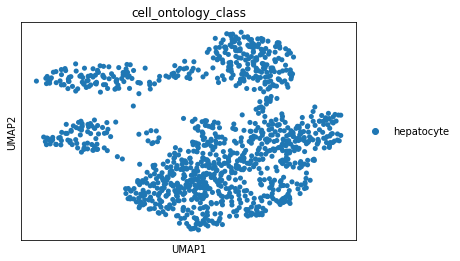

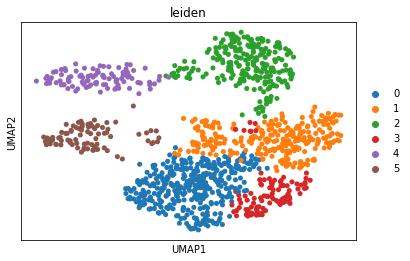

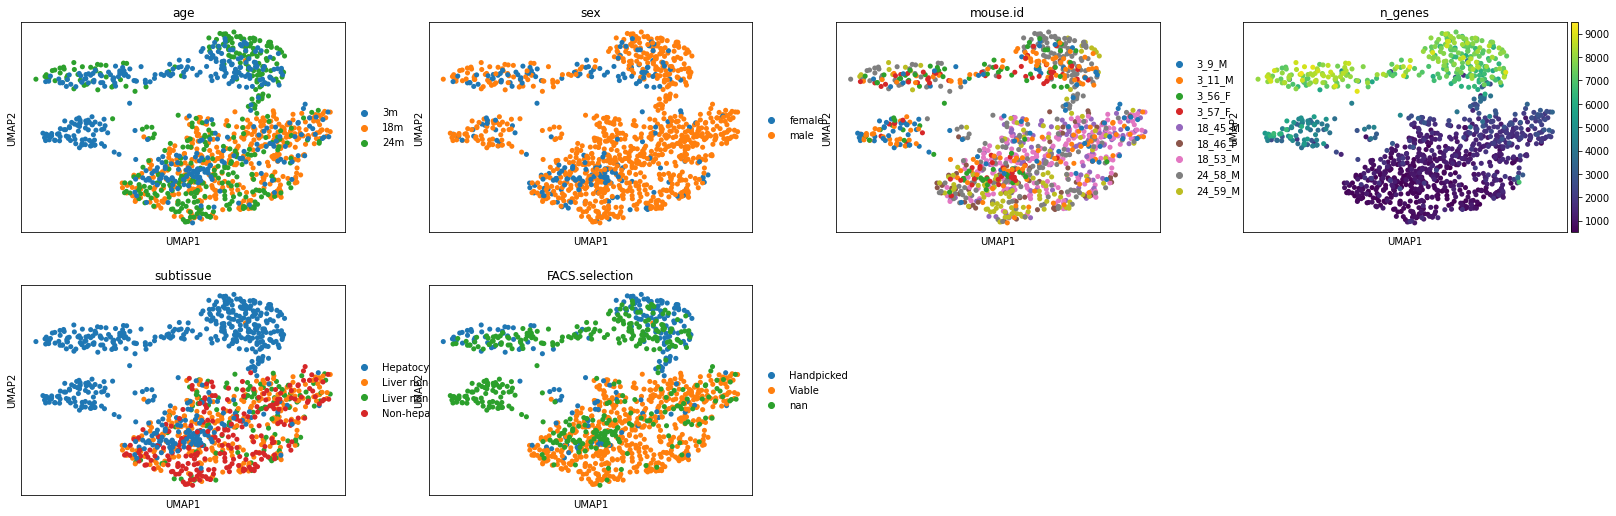

In [5]:
# Reprocess t cell data
for ds in DS_LIST:
    print(ds)
    ind_select = dic_data_raw[ds].obs['cell_ontology_class']=='hepatocyte'
    adata = dic_data_raw[ds][ind_select,:].copy()
    print('Before filtering, n_cell=%d'%adata.shape[0])
    sc.pp.filter_cells(adata, min_genes=250)
    sc.pp.filter_genes(adata, min_cells=50)
    print('After filtering, n_cell=%d'%adata.shape[0])
    adata.obs['batch_harmony'] = adata.obs['mouse.id']
    adata.obs['batch_harmony'] = adata.obs['batch_harmony'].astype('category')

    sc.pp.highly_variable_genes(adata, subset = False, min_disp=.5, 
                                min_mean=.0125, max_mean=10, n_bins=20, n_top_genes=None)
    sc.pp.scale(adata, max_value=10, zero_center=False)
    sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
    sc.external.pp.harmony_integrate(adata, key='batch_harmony', max_iter_harmony=20)
    sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca_harmony")
#     sc.pp.neighbors(adata, n_neighbors=50, n_pcs=20, use_rep="X_pca")
    sc.tl.leiden(adata, resolution=0.7)   
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='cell_ontology_class')
    sc.pl.umap(adata, color='leiden')
    sc.pl.umap(adata, color=['age', 'sex', 'mouse.id', 'n_genes', 'subtissue', 'FACS.selection'])
#     adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/'
#                 'hep.%s.h5ad'%ds)

... storing 'leiden' as categorical


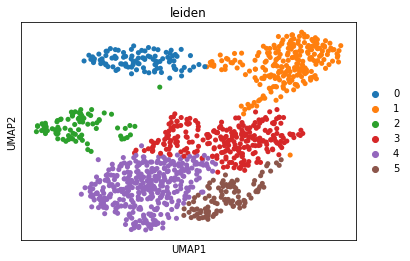

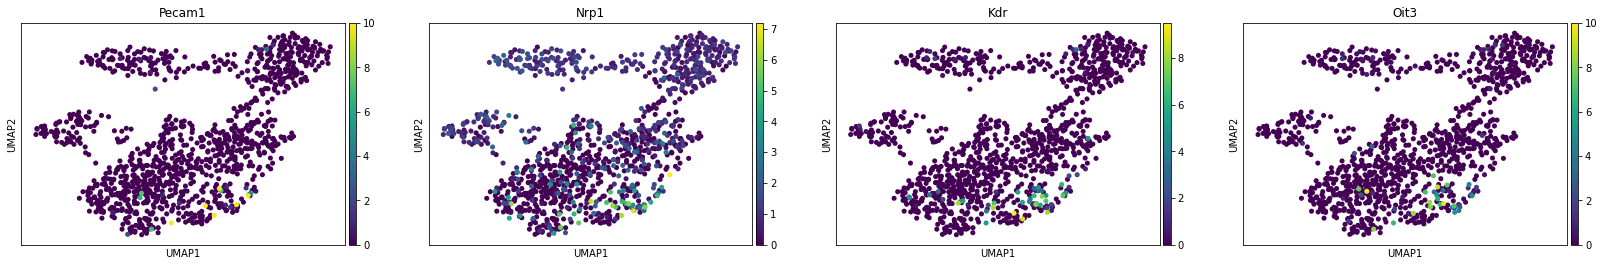

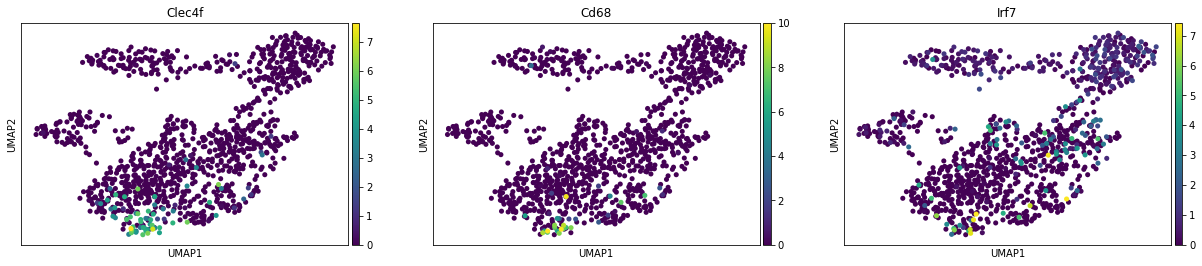

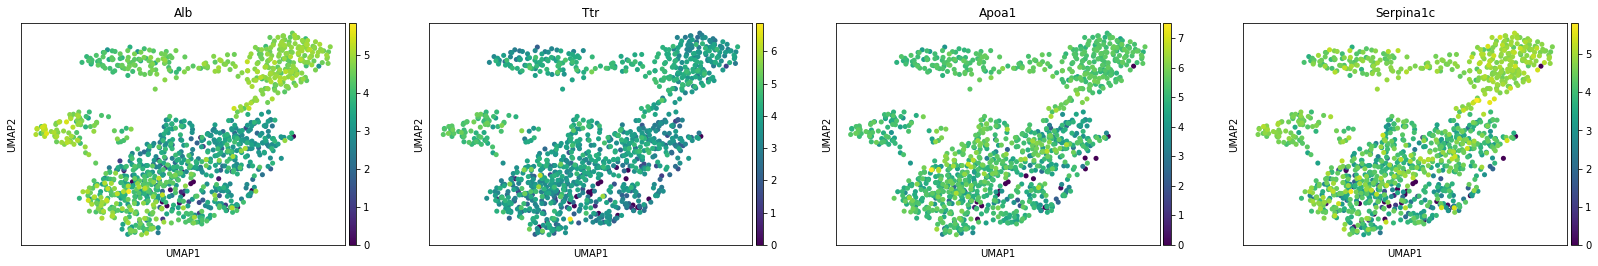

In [8]:
adata = read_h5ad('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/hep.facs.h5ad')
dic_cluster = {'0':'4', '1':'3','2':'1','3':'5','4':'0','5':'2'}
adata.obs['leiden_old'] = adata.obs['leiden'].values
adata.obs['leiden'] = [dic_cluster[x] for x in adata.obs['leiden_old']]
sc.pl.umap(adata, color='leiden')
sc.pl.umap(adata, color=['Pecam1', 'Nrp1', 'Kdr', 'Oit3'])
sc.pl.umap(adata, color=['Clec4f', 'Cd68', 'Irf7'])
sc.pl.umap(adata, color=['Alb', 'Ttr', 'Apoa1', 'Serpina1c'])
adata.write('/n/holystore01/LABS/price_lab/Users/mjzhang/scTRS_data/single_cell_data/tms_proc/hep.facs_annot.h5ad')

In [37]:
temp_df = dic_data_raw['facs'][dic_data_raw['facs'].obs['cell_ontology_class']=='hepatocyte']\
    .obs.groupby(['subtissue', 'mouse.id']).agg({'cell':len})
temp_df.loc[~temp_df['cell'].isna()]

cell
subtissue               mouse.id       
Hepatocytes             3_9_M      64.0
                        3_11_M    110.0
                        3_56_F     82.0
                        3_57_F     79.0
                        24_58_M   174.0
                        24_59_M    40.0
Liver non-hepato/SCs    18_46_F    45.0
                        18_53_M   226.0
Liver non-hepato/SCs_st 18_45_M    94.0
                        18_46_F    18.0
Non-hepatocytes         3_9_M      28.0
                        3_11_M     38.0
                        24_58_M    84.0
                        24_59_M    80.0